# Ansatz according to Opper

$P(z|x_{t+1}) = \alpha \cdot \sum_{z'}P(z|z')P_t(z') \cdot \int P(x_{t+1}|\theta) P(\theta|x_{1:t}) d\theta$

$P(\theta|x_{t+1}) = \alpha \cdot P(\theta | x_{1:t}) \cdot 
    \left. \Bigg( \sum_{z'}P(z_1|z')P_t(z')  P(x_{t+1} | \theta) +\sum_{z'}P(z_2|z')P_t(z') \int P(\theta_2 | x_{1:t})P(x_{t+1}|\theta_2) \; d\theta_2 \right. \Bigg)$
    
with $\int P(x_{t+1}|\theta, 1) P(\theta|\mu_{1:t},1) d\theta = \frac{\sqrt{\pi}}{2\pi}\exp(\frac{(x+\mu_{1:t})^2}{4} - \frac{x_{t+1}^2}{2} - \frac{\mu_{1:t}^2}{2})$

In [1]:
import numpy as np
import math
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import copy
%matplotlib inline 

In [18]:
def TestData(mean=[4,-4], var=[1,1], n=10, skips=20):
    data = np.random.normal(mean[1],var[1],n)
    for i in range(skips):       
        data = np.append(data, np.random.normal(mean[i%2],var[i%2],n))
    return data

In [4]:
def evalFilter(mean=[5,-5], var=[1,1], n=10):
    data = TestData(mean, var, n)
    fA = TwoClassFilter()
    filterData = []
    z0 = []
    z1 = []
    mean0 = []
    mean1 = []
    var0 = []
    var1 = []
    
    for i,x in enumerate(data[:]):
        filterData.append(fA.update(x))
        z0.append(filterData[-1][0][0])
        z1.append(filterData[-1][0][1])
        mean0.append(filterData[-1][1][0])
        mean1.append(filterData[-1][2][0])
        var0.append(filterData[-1][1][1])
        var1.append(filterData[-1][2][1])
    
    fig, ax1 = plt.subplots()
    ax1.set_ylim([-0.2,1.2])
    t = np.arange(0.01, 10.0, 0.01)
    s1 = np.exp(t)
    ax1.plot(range(0,len(data[:])), z0, 'b')
    ax1.plot(range(0,len(data[:])), z1, 'g')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('probability', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    s2 = np.sin(2 * np.pi * t)
    ax2.plot(range(0,len(data[:])), data[:], 'r.')
    ax2.set_ylabel('data values', color='r')
    ax2.tick_params('y', colors='r')
    plt.title("Probability for the two states at each datum")
    plt.show()

    plt.plot(mean0[:1000])
    plt.plot(mean1[:1000])
    plt.scatter(range(0,len(data[:1000])),data[:1000], color='red')
    plt.title('mean of the two states')
    plt.show()

    plt.plot(var0)
    plt.plot(var1)
    plt.show

In [14]:
class TwoClassFilter(object):
    
    def __init__(self):
        self.z = [0.5, 0.5]
        self.transProb0 = [0.9,0.1] #[to itself, to other state]
        self.transProb1 = [0.9,0.1] #[to itself, to other state]
        self.theta0 = [-2,1.1]
        self.theta1 = [2,1.1]
        self.likelihoodParams0 = [self.theta0[0],1]
        self.likelihoodParams1 = [self.theta1[0],1]
        
    def computeTheta(self, _x, _theta):
        theta = _theta
        #compute updated var
        theta[1] = 1.0/(1.0/theta[1] + 1)
        #compute updated mean
        theta[0] = 1.0/(1.0/theta[1] + 1) * (_x + theta[0]/theta[1])
        return theta
    
    def computeIntegral(self, _x, _theta): # it assumes the wrong var for now
        exp = np.exp( (_x + _theta[0])**2/4 - (_x**2-_theta[0]**2)/2 )
        return np.sqrt(np.pi)/(2*np.pi) * exp
    
    def update(self, _x): 
        #compute probability of x beeing from z[0] or z[1]
        #i.e. the likelihood of _x beeing from z
        #which is P(x|theta) = norm(x|theta[mean], 1)
        likelihood0 = scipy.stats.norm(self.likelihoodParams0[0], self.likelihoodParams0[1]).pdf(_x)
        likelihood1 = scipy.stats.norm(self.likelihoodParams1[0], self.likelihoodParams1[1]).pdf(_x)
        #((1-_trans_prob) * _z1) + (_trans_prob * _z2)
        w0 = self.z[0] * self.transProb0[0] + self.z[1] * self.transProb1[1]
        w1 = self.z[1] * self.transProb1[0] + self.z[0] * self.transProb0[1]
        
        integral0 = self.computeIntegral(_x, self.theta0)
        integral1 = self.computeIntegral(_x, self.theta1)
        
        z0 = w0 * integral0
        z1 = w1 * integral1
        
        self.z[0] = z0/(z0+z1)
        self.z[1] = z1/(z0+z1)
        
        if(self.z[0]>self.z[1]):
            self.theta0 = self.computeTheta(_x, self.theta0)
        else:
            self.theta1 = self.computeTheta(_x, self.theta1)
        
        
        self.likelihoodParams0[0] = self.theta0[0]
        self.likelihoodParams1[0] = self.theta1[0]
        return self.z, self.theta0, self.theta1

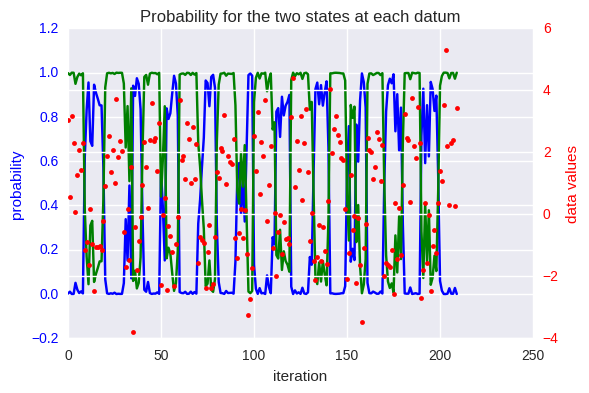

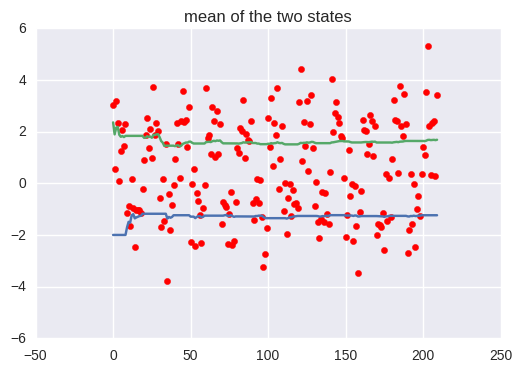

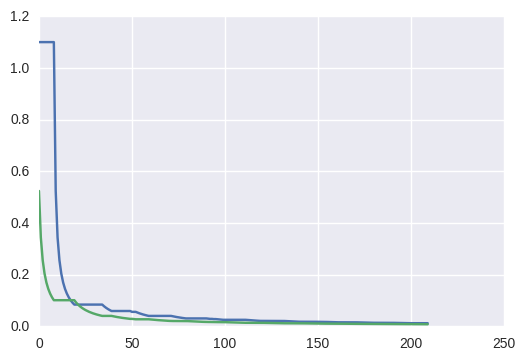

In [19]:
evalFilter(mean=[-1,2])